In [2]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git

  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-i3mux8pz
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-i3mux8pz
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 70ccf00c95a2d78a166cca24ef6adbca46f47c2a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.data import random_split, SubsetRandomSampler
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
import os
import sys
import cv2
import glob
import math
import time
import timm
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from torch import nn, optim
from torchinfo import summary
from tabulate import tabulate
from datetime import timedelta
from functools import lru_cache
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.image as mpimg
from torchvision import transforms
from PIL import Image, ImageEnhance
from joblib import Parallel, delayed
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    matthews_corrcoef, confusion_matrix, classification_report
)

In [4]:
import torchvision.transforms.v2 as v2 
import torchvision
import timm
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [7]:
np.random.seed(42)

In [8]:
train_transform = v2.Compose([
                v2.Resize((224,224)),
                v2.ToTensor()
])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [9]:
directory = '/kaggle/input/imagesoasis/Data'
dataset = ImageFolder(directory, transform=train_transform)

In [10]:
classes = dataset.classes

# Create a mapping from class names to integer labels
class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}

# Create a mapping from integer labels to class names
idx_to_class = {idx: class_name for class_name, idx in class_to_idx.items()}

# Print the mappings
print("Class to Index Mapping:")
print(class_to_idx)

Class to Index Mapping:
{'Mild Dementia': 0, 'Moderate Dementia': 1, 'Non Demented': 2, 'Very mild Dementia': 3}


In [10]:
class_counts = torch.bincount(torch.tensor(dataset.targets))
class_count = np.array(class_counts)
print('Class Count : ', class_count)

Class Count :  [ 5002   488 67222 13725]


In [11]:
from collections import defaultdict


In [12]:
indices = np.arange(len(dataset))
np.random.shuffle(indices)

shuffled_dataset = torch.utils.data.Subset(dataset, indices)

In [13]:

indices_to_keep = []
indices_to_discard = []

# Define the target counts for undersampling
num_undersample_non_demented = 9000
num_undersample_very_mild_dementia = 7000

# Counters to keep track of the number of samples selected from each class
count_non_demented = 0
count_very_mild_dementia = 0

# Iterate through the dataset to select samples
for idx in range(len(shuffled_dataset)):
    _, label = shuffled_dataset[idx]    
    
    if label == 2 and count_non_demented < num_undersample_non_demented:
        indices_to_keep.append(idx)
        count_non_demented += 1
    elif label == 3 and count_very_mild_dementia < num_undersample_very_mild_dementia:
        indices_to_keep.append(idx)
        count_very_mild_dementia += 1
    elif label==1 or label==0:
        # For labels 0 and 1, simply add the index to the list of indices to keep
        indices_to_keep.append(idx)
print(len(indices_to_keep))
# print(indices_to_keep)

# Randomly shuffle the indices to keep
np.random.shuffle(indices_to_keep)

# Select the required number of samples to keep from the shuffled list of indices
# indices_to_keep = indices_to_keep[:num_undersample_non_demented + num_undersample_very_mild_dementia]

# Create a subset dataset with the selected indices
undersampled_dataset = torch.utils.data.Subset(shuffled_dataset, indices_to_keep)

# Print the number of samples selected and discarded
print(f"Number of samples selected: {len(indices_to_keep)}")
print(f"Number of samples discarded: {len(shuffled_dataset) - len(indices_to_keep)}")


21490
Number of samples selected: 21490
Number of samples discarded: 64947


In [14]:
labels = [label for _, label in undersampled_dataset]

test_ratio = 0.2
val_ratio = 0.2

# Initialize StratifiedShuffleSplit for test split
test_split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)

# Get indices for stratified split for test
train_val_indices, test_index = next(test_split.split(np.zeros(len(labels)), labels))

# Initialize StratifiedShuffleSplit for validation split
val_split = StratifiedShuffleSplit(n_splits=1, test_size=val_ratio / (1 - test_ratio), random_state=42)

# Get indices for stratified split for validation
train_index, val_index = next(val_split.split(train_val_indices, [labels[i] for i in train_val_indices]))

# Create data loaders for each split
train_dataset = torch.utils.data.Subset(undersampled_dataset, train_index)
val_dataset = torch.utils.data.Subset(undersampled_dataset, val_index)
test_dataset = torch.utils.data.Subset(undersampled_dataset, test_index)

In [15]:
# Define data loaders for each split
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)


In [30]:
from collections import defaultdict

# Initialize a dictionary to store the count of images for each class
class_counts = defaultdict(int)

# Iterate through the dataset and count the occurrences of each class
for _, label in undersampled_dataset:
    class_counts[label] += 1

# Print the count of images for each class
for class_label, count in class_counts.items():
    print(f"Class {class_label}: {count} images")


Class 0: 5002 images
Class 2: 9000 images
Class 1: 488 images
Class 3: 7000 images


In [16]:
def custom_metrics(y_pred, y_true, loss):
    """
    Calculate custom evaluation metrics for multiclass classification.

    Args:
        y_pred (Tensor): Predicted probabilities for each class.
        y_true (Tensor): True labels.
        loss (float): Loss value.

    Returns:
        dict: Dictionary containing computed metrics.
    """
    # Calculate predicted class labels
    y_pred_classes = torch.argmax(y_pred, dim=1)

    # Calculate accuracy using predicted and true labels
    y_true_numpy = y_true.cpu().numpy()
    y_pred_classes_numpy = y_pred_classes.cpu().numpy()
    accuracy = accuracy_score(y_true_numpy, y_pred_classes_numpy)

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    recall = recall_score(y_true_numpy, y_pred_classes_numpy, average='weighted')
    f1 = f1_score(y_true_numpy, y_pred_classes_numpy, average='weighted')

    # Compute confusion matrix for multiclass classification
    cm = confusion_matrix(y_true_numpy, y_pred_classes_numpy)
    
    # Calculate specificity, sensitivity, and MCC for multiclass classification
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    fn = cm[1:, 0].sum()
    tp = cm[1:, 1:].sum()

    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)

    mcc = matthews_corrcoef(y_true_numpy, y_pred_classes_numpy)

    # Calculate AUC for each class
    num_classes = y_pred.shape[1]
    auc_scores = []

    for class_idx in range(num_classes):
        class_y_true = (y_true_numpy == class_idx).astype(np.float32)
        class_y_pred = y_pred[:, class_idx].cpu().numpy()
        auc_score = roc_auc_score(class_y_true, class_y_pred)
        auc_scores.append(auc_score)

    # Average AUC across classes
    auc_avg = np.mean(auc_scores)

    # Create a dictionary to store metrics
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "specificity": specificity,
        "sensitivity": sensitivity,
        "mcc": mcc,
        "auc": auc_avg,
    }

    return metrics

In [17]:
num_classes = 4

# Create the model
model = timm.create_model('pit_ti_224', pretrained=True)

# Modify the model's output head
model.head = torch.nn.Linear(model.head.in_features, num_classes)

# Move the model to the specified device
model.to(device)

# Print the model summary
summary(model, (3, 224, 224))  #

model.safetensors:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

Layer (type:depth-idx)                             Output Shape              Param #
PoolingVisionTransformer                           [1, 4]                    46,720
├─ConvEmbedding: 1-1                               [64, 27, 27]              --
│    └─Conv2d: 2-1                                 [64, 27, 27]              49,216
├─Dropout: 1-2                                     [1, 64, 27, 27]           --
├─SequentialTuple: 1-3                             [1, 256, 7, 7]            --
│    └─Transformer: 2-2                            [1, 64, 27, 27]           --
│    │    └─Identity: 3-1                          [1, 730, 64]              --
│    │    └─Sequential: 3-2                        [1, 730, 64]              99,968
│    └─Transformer: 2-3                            [1, 128, 14, 14]          --
│    │    └─Pooling: 3-3                           [1, 128, 14, 14]          9,600
│    │    └─Identity: 3-4                          [1, 197, 128]             --
│    │    └─Sequenti

In [18]:
from torch.optim.lr_scheduler import StepLR

# scheduler = StepLR(optimizer, step_size=8, gamma=0.95)

LR = 0.00095
BATCH_SIZE = 64

optimizer = torch.optim.Adam(model.parameters(), lr = LR)

criterion = torch.nn.CrossEntropyLoss() 
# criterion_DRW = torch.nn.CrossEntropyLoss(weight = weight)


In [19]:
total_epochs = 50

# Initialize lists to store metric values for each epoch
metric_names = ["loss", "accuracy", "precision", "recall", "f1_score", "specificity", "sensitivity", "mcc", "auc"]
train_metrics_history = {metric_name: [] for metric_name in metric_names}
val_metrics_history = {metric_name: [] for metric_name in metric_names}

# Training and validation loop
total_training_time = 0.0
total_validation_time = 0.0

for epoch in range(total_epochs):
    start_time = time.time()
    
    # Training phase
    model.train()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    for batch_idx, (data, targets) in enumerate(tqdm(train_loader, desc=f"Training Model - Epoch [{epoch + 1}/{total_epochs}]")):
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
#         optimizer.step()

        total_loss += loss.item()

        all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
        all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_training_time = end_time - start_time
    total_training_time += epoch_training_time
    average_loss = total_loss / len(train_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    train_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print training metrics in one line
    training_metrics_line = "Metrics - "
    for metric_name, metric_value in train_metrics.items():
        if metric_name == 'auc':
            training_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            training_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{training_metrics_line}")

    for metric_name in metric_names:
        train_metrics_history[metric_name].append(train_metrics[metric_name])

    # Validation phase
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    start_time = time.time()

    with torch.no_grad():
        for batch_idx, (data, targets) in enumerate(tqdm(val_loader, desc="Validating Model: ")):
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.extend(torch.softmax(outputs, dim=1).cpu().detach().numpy())
            all_targets.extend(targets.cpu().numpy())

    end_time = time.time()
    epoch_validation_time = end_time - start_time
    total_validation_time += epoch_validation_time
    average_loss = total_loss / len(val_loader)

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    
    val_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

    # Print validation metrics in one line
    validation_metrics_line = "Metrics - "
    for metric_name, metric_value in val_metrics.items():
        if metric_name == 'auc':
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}"
        else:
            validation_metrics_line += f"{metric_name}: {metric_value:.4f}, "

    print(f"{validation_metrics_line}")
    
    for metric_name in metric_names:
        val_metrics_history[metric_name].append(val_metrics[metric_name])

# Calculate and display total time taken for training and validation
print(f"Total Training Time: {str(timedelta(seconds=total_training_time))}")
print(f"Total Validation Time: {str(timedelta(seconds=total_validation_time))}")

# Calculate and display average time taken per epoch for training and validation
avg_training_time_per_epoch = total_training_time / total_epochs
avg_validation_time_per_epoch = total_validation_time / total_epochs
print(f"Average Training Time per Epoch: {str(timedelta(seconds=avg_training_time_per_epoch))}")
print(f"Average Validation Time per Epoch: {str(timedelta(seconds=avg_validation_time_per_epoch))}")

Training Model - Epoch [1/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [2/50]: 100%|██████████| 202/202 [00:30<00:00,  6.67it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [3/50]: 100%|██████████| 202/202 [00:30<00:00,  6.68it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [4/50]: 100%|██████████| 202/202 [00:30<00:00,  6.68it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.67it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [5/50]: 100%|██████████| 202/202 [00:30<00:00,  6.68it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [6/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [7/50]: 100%|██████████| 202/202 [00:30<00:00,  6.62it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.38it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [8/50]: 100%|██████████| 202/202 [00:30<00:00,  6.60it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.38it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [9/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.41it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [10/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.75it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [11/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.78it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [12/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.38it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [13/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.74it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [14/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [15/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.37it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [16/50]: 100%|██████████| 202/202 [00:30<00:00,  6.58it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.64it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [17/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [18/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.37it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [19/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.76it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [20/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.40it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [21/50]: 100%|██████████| 202/202 [00:30<00:00,  6.67it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.48it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [22/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.59it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [23/50]: 100%|██████████| 202/202 [00:30<00:00,  6.62it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [24/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.42it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [25/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.58it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [26/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.62it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [27/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [28/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.28it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [29/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.31it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [30/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.49it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [31/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.60it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [32/50]: 100%|██████████| 202/202 [00:30<00:00,  6.67it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.37it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [33/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.54it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [34/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.49it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [35/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.38it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [36/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.68it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [37/50]: 100%|██████████| 202/202 [00:30<00:00,  6.62it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [38/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.47it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [39/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.65it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [40/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.52it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [41/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.79it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [42/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.68it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [43/50]: 100%|██████████| 202/202 [00:30<00:00,  6.64it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.77it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [44/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.20it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [45/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.92it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [46/50]: 100%|██████████| 202/202 [00:30<00:00,  6.65it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:09<00:00,  7.37it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [47/50]: 100%|██████████| 202/202 [00:30<00:00,  6.67it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.83it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [48/50]: 100%|██████████| 202/202 [00:30<00:00,  6.66it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.86it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [49/50]: 100%|██████████| 202/202 [00:30<00:00,  6.63it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.70it/s]


Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171


Training Model - Epoch [50/50]: 100%|██████████| 202/202 [00:30<00:00,  6.67it/s]


Metrics - loss: 1.4059, accuracy: 0.2811, precision: 0.3684, recall: 0.2811, f1_score: 0.2642, specificity: 0.1803, sensitivity: 0.8338, mcc: 0.0379, auc: 0.5021


Validating Model: 100%|██████████| 68/68 [00:08<00:00,  7.69it/s]

Metrics - loss: 1.4034, accuracy: 0.2857, precision: 0.3669, recall: 0.2857, f1_score: 0.2685, specificity: 0.1700, sensitivity: 0.8420, mcc: 0.0424, auc: 0.5171
Total Training Time: 0:25:19.965593
Total Validation Time: 0:07:29.371262
Average Training Time per Epoch: 0:00:30.399312
Average Validation Time per Epoch: 0:00:08.987425


In [20]:
# Testing loop
model.eval()
total_loss = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    # Wrap the testing data loader with tqdm for a progress bar
    for batch_idx, (data, targets) in enumerate(tqdm(test_loader, desc="Testing Model")):
        data = data.to(device)
        targets = targets.to(device)

        outputs = model(data)
        loss = criterion(outputs, targets)
        total_loss += loss.item()

        # Store predictions and targets for metrics
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_targets.extend(targets.detach().cpu().numpy())

# Convert lists to NumPy arrays before creating PyTorch tensors
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

average_loss = total_loss / len(test_loader)
test_metrics = custom_metrics(torch.tensor(all_predictions), torch.tensor(all_targets), average_loss)

# Print testing metrics in one line
testing_metrics_line = "Metrics - "
for metric_name, metric_value in test_metrics.items():
    if metric_name == 'auc':
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}"
    else:
        testing_metrics_line += f"{metric_name}: {metric_value:.4f}, "

print(f"{testing_metrics_line}")

Testing Model: 100%|██████████| 68/68 [00:09<00:00,  7.08it/s]

Metrics - loss: 1.4030, accuracy: 0.2855, precision: 0.3515, recall: 0.2855, f1_score: 0.2674, specificity: 0.1840, sensitivity: 0.8390, mcc: 0.0448, auc: 0.5231


In [29]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Convert true_labels and predicted_labels to numpy arrays
true_labels = np.array(all_targets)

# Assuming predicted_labels are probabilities, convert them to class labels
predicted_labels = np.argmax(np.array(all_predictions), axis=1)

# Ensure both true_labels and predicted_labels are of integer type
true_labels = true_labels.astype(int)
predicted_labels = predicted_labels.astype(int)

# Get unique class labels from true_labels and predicted_labels
unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))

# print(idx_to_class)
# Generate a classification report
report = classification_report(true_labels, predicted_labels, labels=unique_labels, target_names=[idx_to_class[label] for label in idx_to_class], digits=4)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
num_errors = np.sum(true_labels != predicted_labels)

print(report)
print(f'There were {num_errors} errors in {len(predicted_labels)} tests for an accuracy of {accuracy*100:6.2f}')

                    precision    recall  f1-score   support

     Mild Dementia     0.2573    0.1840    0.2146      1000
 Moderate Dementia     0.0269    0.3878    0.0503        98
      Non Demented     0.4660    0.5528    0.5057      1800
Very mild Dementia     0.2941    0.0071    0.0139      1400

          accuracy                         0.2855      4298
         macro avg     0.2611    0.2829    0.1961      4298
      weighted avg     0.3515    0.2855    0.2674      4298

There were 3071 errors in 4298 tests for an accuracy of  28.55


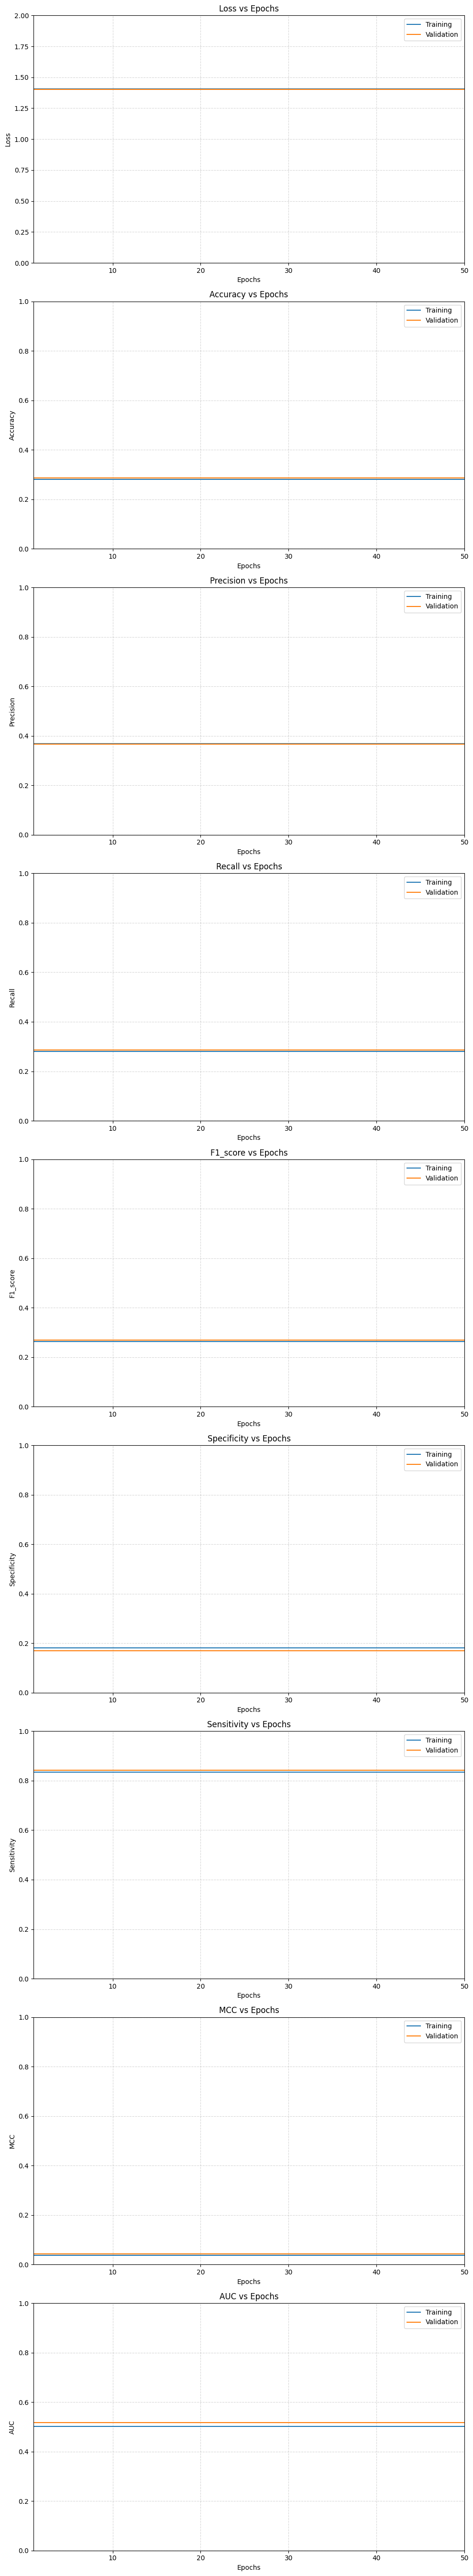

In [22]:
def plot_metrics(train_metrics_history, val_metrics_history, metric_names):
    """
    Plots the given metrics for the training and validation sets.

    Args:
        train_metrics_history: a dictionary containing training metrics history
        val_metrics_history: a dictionary containing validation metrics history
        metric_names: a list of strings representing the names of the metrics to plot

    Returns:
        None
    """
    num_metrics = len(metric_names)
    num_epochs = len(train_metrics_history[metric_names[0]])

    figure, axes = plt.subplots(num_metrics, figsize=(10, 6 * num_metrics))

    rng = range(1, num_epochs + 1)

    for ax, metric_name in zip(axes, metric_names):
        train_metric = train_metrics_history[metric_name]
        val_metric = val_metrics_history[metric_name]

        ax.plot(rng, train_metric, label="Training")
        ax.plot(rng, val_metric, label="Validation")
        ax.legend()
        ax.set_xlabel("Epochs")

        if metric_name in ("auc", "mcc"):
            ax.set_ylabel(metric_name.upper())
            ax.set_title(metric_name.upper() + " vs Epochs")
        else:
            ax.set_ylabel(metric_name.capitalize())
            ax.set_title(metric_name.capitalize() + " vs Epochs")

        max_metric = max(max(train_metric), max(val_metric))
        min_metric = min(min(train_metric), min(val_metric))
        y_max = math.ceil(max_metric)

        if min_metric > 0 or max_metric > 1:
            ax.set_ylim(0, y_max)
        else:
            ax.set_ylim(min_metric, y_max)

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlim(1, num_epochs)

    plt.tight_layout()
    plt.show()

plot_metrics(train_metrics_history, val_metrics_history, metric_names)